# EDA Análisis exploratorio de datos

En este EDA voy a usar los datos proporcionados por la pagina de [Buenos Aires](https://data.buenosaires.gob.ar/dataset/victimas-siniestros-viales) para poder analizar la cantidad de siniestros viales que ocurren en la Ciudad de Buenos Aires

## Importando librerías

In [1]:
import re
import sketch
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
import geojson
import warnings
warnings.filterwarnings("ignore")
import folium
from folium.plugins import HeatMap
from summarytools import dfSummary

### Ingesta de datos desde el dataset limpio `siniestros_limpio`

In [2]:
df= pd.read_csv("data/siniestos_limpio.csv")
df.head(3)

,Id,Fecha,Año,Mes,Día,Día semana,Hora completa,Hora,Num víctimas,Participantes,...,Calle,Cruce,Dirección normalizada,Comuna,Barrios,Xy (caba),Coordenada x,Coordenada y,Pos x,Pos y
0,2016-0001,2016-01-01,2016.0,1.0,1.0,Viernes,04:00:00,4.0,1,MOTO-AUTO,...,PIEDRA BUENA AV.,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",Comuna 8,VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI,Point (98896.78238426 93532.43437792),98896.782384,93532.434378,-58.475340,-34.687570
1,2016-0002,2016-01-02,2016.0,1.0,2.0,Sabado,01:15:00,1.0,1,AUTO-PASAJEROS,...,"PAZ, GRAL. AV.",DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",Comuna 9,LINIERS - MATADEROS - PARQUE AVELLANEDA,Point (95832.05571093 95505.41641999),95832.055711,95505.416420,-58.508775,-34.669777
2,2016-0003,2016-01-03,2016.0,1.0,3.0,Domingo,07:00:00,7.0,1,MOTO-AUTO,...,ENTRE RIOS AV.,NaN,ENTRE RIOS AV. 2034,Comuna 1,CONSTITUCION - MONTSERRAT - PUERTO MADERO - RE...,Point (106684.29090040 99706.57687843),106684.290900,99706.576878,-58.390403,-34.631894


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     717 non-null    object 
 1   Fecha                  702 non-null    object 
 2   Año                    702 non-null    float64
 3   Mes                    702 non-null    float64
 4   Día                    702 non-null    float64
 5   Día semana             702 non-null    object 
 6   Hora completa          702 non-null    object 
 7   Hora                   701 non-null    float64
 8   Num víctimas           717 non-null    int64  
 9   Participantes          702 non-null    object 
 10  Rol                    717 non-null    object 
 11  Acusado                702 non-null    object 
 12  Victima                702 non-null    object 
 13  Sexo                   717 non-null    object 
 14  Edad                   717 non-null    int64  
 15  Rango 

### Outliers

Se realiza la busqueda de datos con valores atípicos en las features, y se analiza si es necesario eliminarlos.  

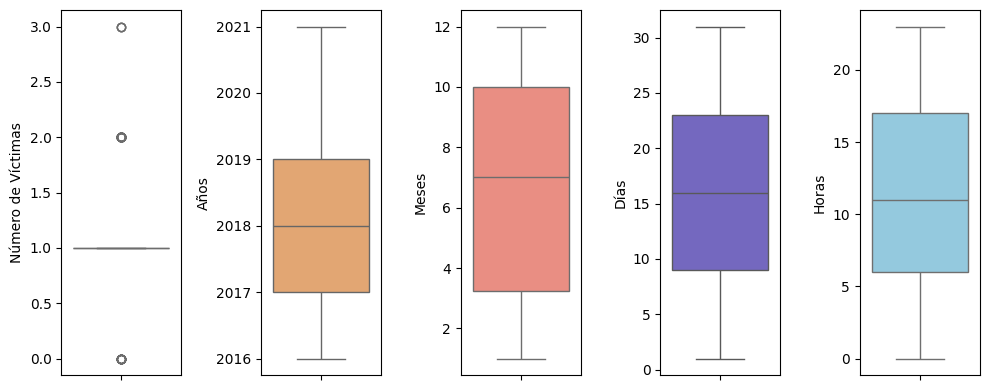

In [4]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(10, 4))

# Crear subplots para los gráficos 
plt.subplot(1, 5, 1) 
sns.boxplot(data=df, y='Num víctimas', color = "#FA8072")
plt.ylabel('Número de Víctimas')

plt.subplot(1, 5, 2) 
sns.boxplot(data=df, y='Año', color = "#F4A460")
plt.ylabel('Años')

plt.subplot(1, 5, 3) 
sns.boxplot(data=df, y='Mes', color = "#FA8072")
plt.ylabel('Meses')

plt.subplot(1, 5, 4) 
sns.boxplot(data=df, y='Día', color = "#6A5ACD")
plt.ylabel('Días')

plt.subplot(1, 5, 5) 
sns.boxplot(data=df, y='Hora', color = "#87CEEB")
plt.ylabel('Horas')

# Ajustar espaciado entre subplots
plt.tight_layout()

plt.show()

#### **Conclusión**
- Los Outliers que se encuentran en feature `Num víctimas` (valores 2 ó 3), se producen debido a que en la mayoria de los casos el registro es el valor uno (1); con respecto a las victimas en los siniestros. 

### `Num víctimas`
- Cantidad de víctimas fatales por siniestro vial

In [5]:
df["Num víctimas"].describe()

count    717.000000
mean       1.037657
std        0.294226
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: Num víctimas, dtype: float64

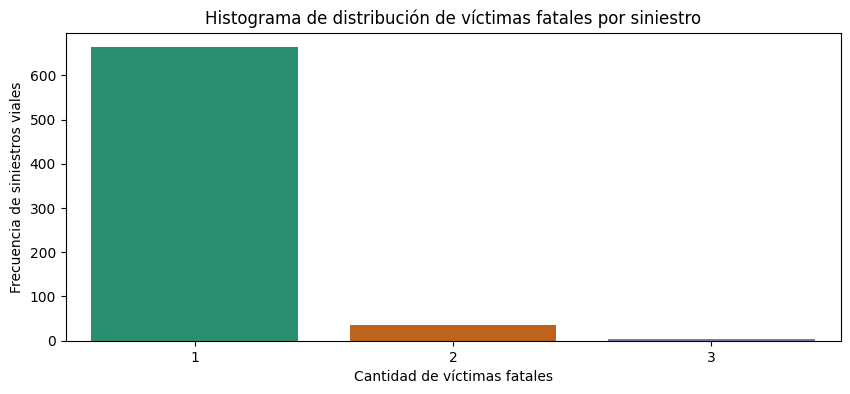

In [6]:
plt.figure(figsize=(10, 4))
# se filtran los valores sin datos o nulos 
df_filtrado = df[df["Num víctimas"] != 0]

#Se cuentan los datos de la columna y se calcula la frecuencia en que se distribuye
sns.countplot(df_filtrado, x='Num víctimas', palette="Dark2")

plt.ylabel("Frecuencia de siniestros viales")
plt.xlabel("Cantidad de víctimas fatales")
plt.title("Histograma de distribución de víctimas fatales por siniestro")

plt.show()

#### **Conclusión**
- La cantidad de víctimas fatales que arrojan los siniestros viales es de 1 (una), en la mayoría de los casos. 
- Según los datos estadísticos de la columna el 75% de los siniestros viales tienen 1 víctima.
- Rara vez resulta un siniestro con tres víctimas fatales 

#### Relación `Num vìctimas` con el tiempo - Distribución temporal

Se analizan los datos teniendo en cuenta diferentes horizontes temporales, para corroborar la existencia de algún tipo de evento o patrón importante.

In [7]:
# Agrupar por año y mes, y sumar el número de víctimas
rel_tiempo = df.groupby(['Año', 'Mes'])['Num víctimas'].sum().reset_index()

In [8]:
rel_tiempo

,Año,Mes,Num víctimas
0,2016.0,1.0,8
1,2016.0,2.0,12
2,2016.0,3.0,15
3,2016.0,4.0,9
4,2016.0,5.0,7
...,...,...,...
67,2021.0,8.0,9
68,2021.0,9.0,4
69,2021.0,10.0,5
70,2021.0,11.0,8


In [9]:
#Para la realización del gráfico se transforman los datos a tipo int
rel_tiempo["Año"]= rel_tiempo["Año"].astype("Int64")
rel_tiempo["Mes"]= rel_tiempo["Mes"].astype("Int64")

In [10]:
rel_tiempo

,Año,Mes,Num víctimas
0,2016,1,8
1,2016,2,12
2,2016,3,15
3,2016,4,9
4,2016,5,7
...,...,...,...
67,2021,8,9
68,2021,9,4
69,2021,10,5
70,2021,11,8


In [11]:
# Combinar AÑO y MES para obtener una sola variable de tiempo, creando la columna "Fecha" como str
rel_tiempo["Fecha"] = rel_tiempo["Año"].astype(str) + '-' + rel_tiempo["Mes"].astype(str)

# Convertir la variable de tiempo a formato datetime
rel_tiempo["Fecha"] = pd.to_datetime(rel_tiempo["Fecha"])

# Ordenar el DataFrame por fecha para que tenga orden cronológico
rel_tiempo = rel_tiempo.sort_values("Fecha")

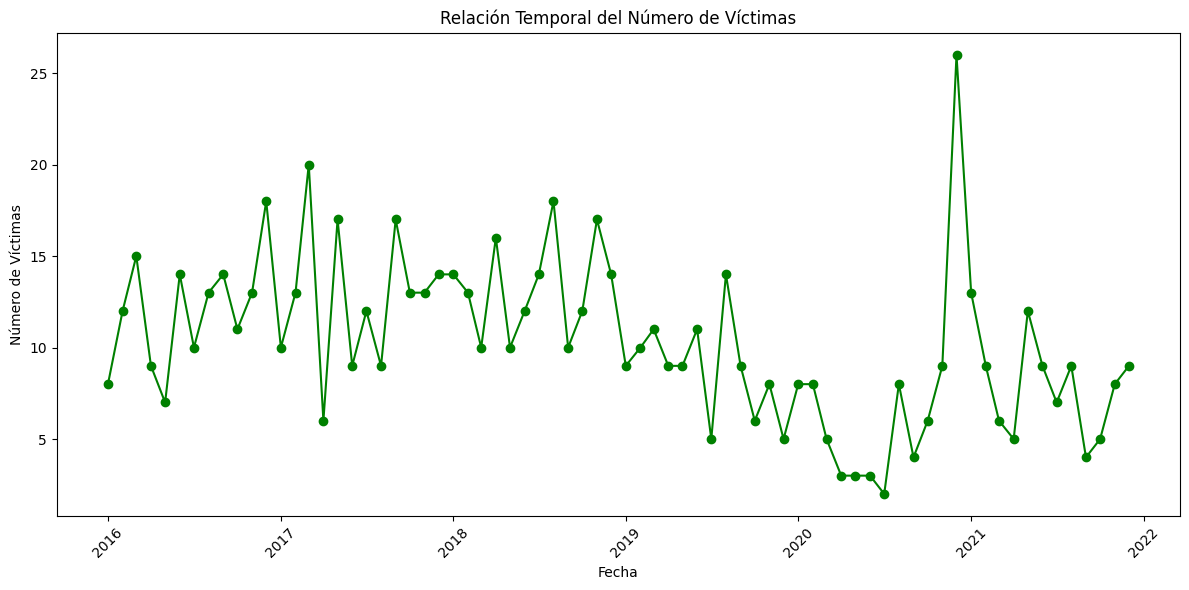

In [12]:
# Crear el gráfico de líneas
plt.figure(figsize=(12, 6))
plt.plot(rel_tiempo["Fecha"], rel_tiempo["Num víctimas"], marker='o', color='green')

# Añadir títulos y etiquetas
plt.title('Relación Temporal del Número de Víctimas')
plt.xlabel('Fecha')
plt.ylabel('Número de Víctimas')

# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

#### **Conclusión**
- En el gráfico de la relación temporal del número de víctimas, se muestra como las fechas con mayor cantidad de siniestros fatales se dan durante 2017 y 2018; luego se percibe una disminución sostenida en los siguientes años. Sólo hubo un pico, a finales de 2020 superando el mayor número de víctimas mesuales a lo largo de los años analizados (26 víctimas fatales). 
- Durante el año 2020, la llegada de la pandemia COVID19; influyó notablemente en las estadísticas de siniestros viales

### Distribución temporal de víctimas 

#### Distribución mensual de víctimas fatales

Se crea un gráfico de barras que muestra la cantidad de víctimas por mes y agrega etiquetas de número de víctimas en cada barra.

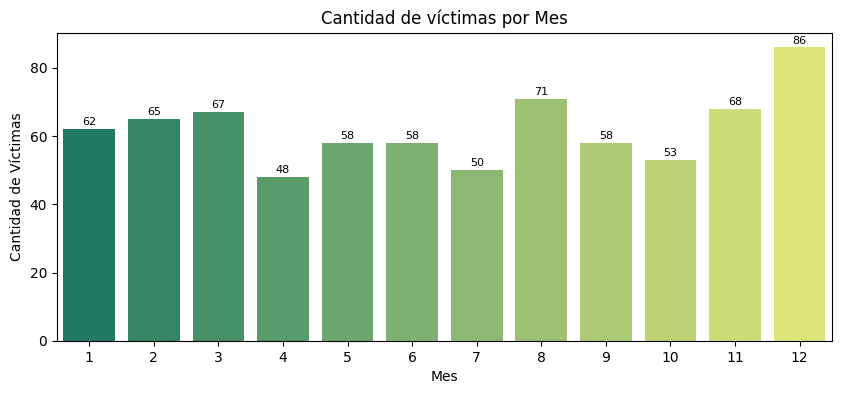

In [13]:
# Se agrupa por la cantidad de víctimas por mes
data = df.groupby(['Mes'])['Num víctimas'].sum().reset_index()
data["Mes"]=data["Mes"].astype("Int64")

# Se grafica
plt.figure(figsize=(10,4))

ax = sns.barplot(x='Mes', y='Num víctimas', data=data, palette="summer")
ax.set_title('Cantidad de víctimas por Mes')
ax.set_xlabel('Mes') ; ax.set_ylabel('Cantidad de Víctimas')

# Agregar etiquetas de número de víctimas en cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

# Se muestra el gráfico
plt.show()

Se crea un gráfico de barras que muestra la cantidad de víctimas por día de la semana y agrega etiquetas de número de víctimas en cada barra.

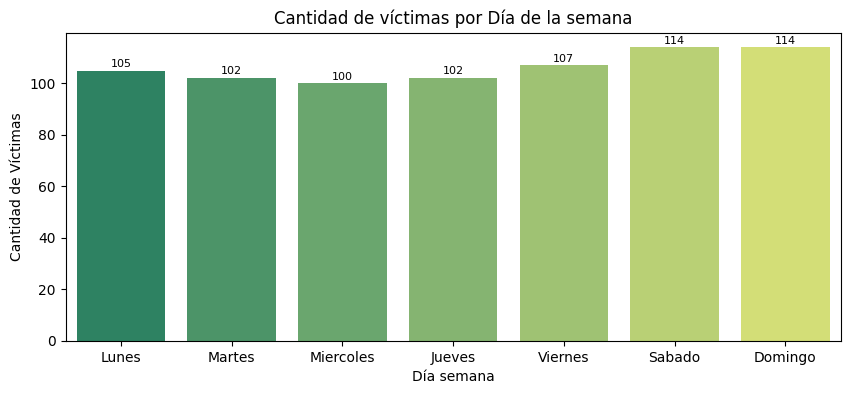

In [14]:
# Se agrupa por la cantidad de víctimas por dia semana
data = df.groupby(['Día semana'])['Num víctimas'].sum().reset_index()


# Define el orden de los días de la semana
orden_dias_semana = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]

# Crea una columna 'Orden_dia_semana' en el DataFrame para representar el orden numérico de los días de la semana
data['Orden_dia_semana'] = data['Día semana'].apply(lambda x: orden_dias_semana.index(x))

# Ordena el DataFrame según el orden numérico de los días de la semana
data = data.sort_values(by='Orden_dia_semana')



# Se grafica
plt.figure(figsize=(10,4))

ax = sns.barplot(x='Día semana', y='Num víctimas', data=data, palette="summer")
ax.set_title('Cantidad de víctimas por Día de la semana')
ax.set_xlabel('Día semana') ; ax.set_ylabel('Cantidad de Víctimas')

# Agregar etiquetas de número de víctimas en cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

# Se muestra el gráfico
plt.show()


#### Distribución relacionando horas y días, de víctimas fatales

Se crea un mapa de calor donde el eje x representa las horas del día, el eje y representa los días de la semana y el color de cada celda indica el número de víctimas. Se utiliza Seaborn para crear el mapa de calor y el argumento annot=True agrega los valores numéricos en las celdas del mapa de calor.


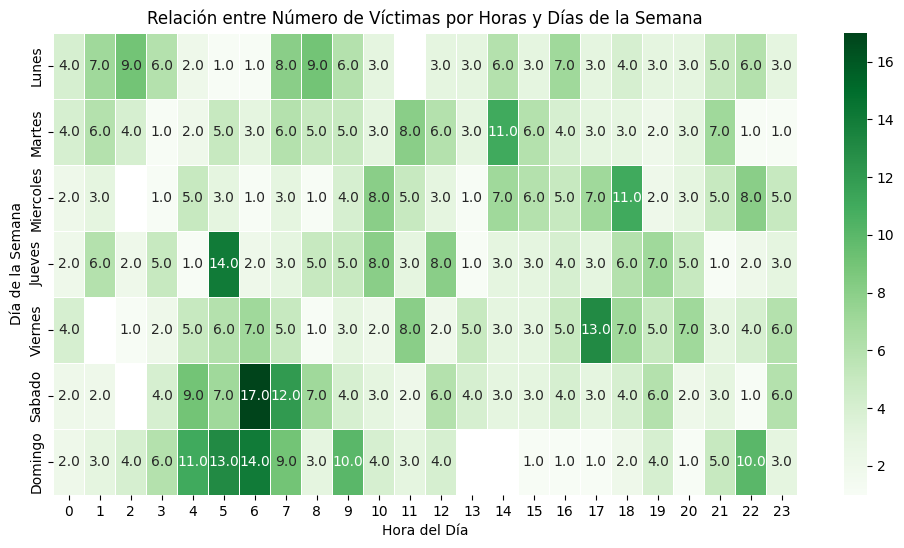

In [15]:
#Agrupa los datos en cantidad de victimas por dia de la semana y horas 
data = df.groupby(['Día semana', "Hora"])['Num víctimas'].sum().reset_index()
data["Hora"]=data["Hora"].astype("Int64")

# Define el orden de los días de la semana
orden_dias_semana = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]

# Crea una columna 'Orden_dia_semana' en el DataFrame para representar el orden numérico de los días de la semana
data['Orden_dia_semana'] = data['Día semana'].apply(lambda x: orden_dias_semana.index(x))

# Ordena el DataFrame según el orden numérico de los días de la semana
data = data.sort_values(by='Orden_dia_semana')

# Crear una tabla pivot para los datos
pivot_data = data.pivot_table(index= 'Día semana', columns='Hora', values='Num víctimas', aggfunc='sum')
pivot_data = pivot_data.reindex(orden_dias_semana)

# Crear un mapa de calor (heatmap)
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, cmap='Greens', annot=True, fmt='.1f', linewidths=0.5)

# Configurar etiquetas y título
plt.xlabel('Hora del Día')
plt.ylabel('Día de la Semana')
plt.title('Relación entre Número de Víctimas por Horas y Días de la Semana')

# Mostrar el gráfico
plt.show()

#### **Conclusión**
- El mes con mayor cantidad de `víctimas fatales` (86) es Diciembre .
- Los días `Sábado y Domingo` tienen la suma de 114 víctimas fatales, siendo la mayor cantidad.
- El mapa de calor indica que los días de fin de semana, en especial sábados y domingos se encuentran con un número más alto de víctimas fatales, siendo las horas entre 03.00 hs y 09.00 hs

Puede decirse que los horarios con mayor peligrosidad tienen que ver con el ingreso laboral (05:00 hs - 09:00 hs), el horario del mediodía (12:00 hs - 14:00 hs) y salida del trabajo (17:00 hs - 18:00 hs). Durante la madrugada existen pocos siniestros. Y los fines de semana los la cantidad de siniestros es poca pero con mayor cantidad de víctimas

### `Edad` de las víctimas

Se crea un histograma de edades de las víctimas fatales y se utiliza el mismo eje para mostrar las estadísticas de la columna edades a través de un boxplot

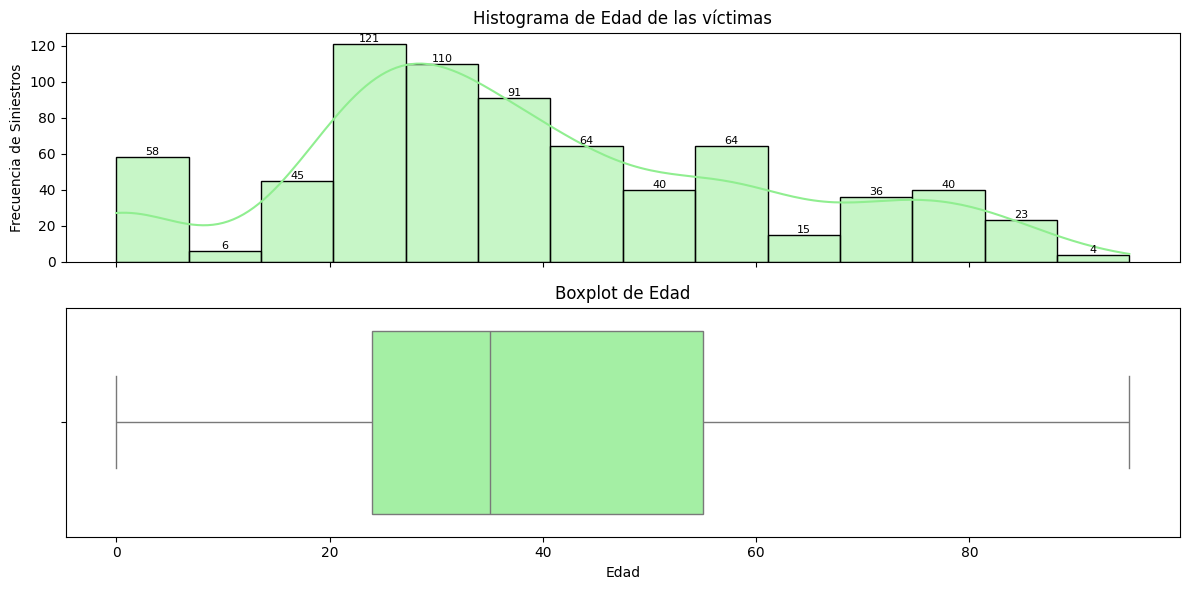

In [16]:
# Se crea una figura con un solo eje x compartido para tener dos gráficos en uno
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Se grafica el histograma de la edad
sns.histplot(df['Edad'], kde=True, ax=ax[0], color='lightgreen') #se agrega la línea de suavizado
ax[0].set_title('Histograma de Edad de las víctimas') ; ax[0].set_ylabel('Frecuencia de Siniestros')

# Agregar etiquetas de datos en el histograma
for p in ax[0].patches:
    ax[0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=8, color='black')

# Se grafica el boxplot de la edad
sns.boxplot(x=df['Edad'], ax=ax[1], color='palegreen')
ax[1].set_title('Boxplot de Edad') ; ax[1].set_xlabel('Edad')

# Se ajusta y muestra el gráfico
plt.tight_layout()
plt.show()


In [17]:
df["Edad"].describe()

count    717.000000
mean      39.050209
std       22.010669
min        0.000000
25%       24.000000
50%       35.000000
75%       55.000000
max       95.000000
Name: Edad, dtype: float64

En una visualización en general se puede observar que el 75% de las víctimas fatales es menor que 55 años, la mediana es de 39 años.
Con respecto a la distribución del histograma, puede concluirse que la mayor cantiad de víctimas fatales se concentra entre los 20 a 40 años de edad

### Distribución etaria  de víctimas según `Sexo`

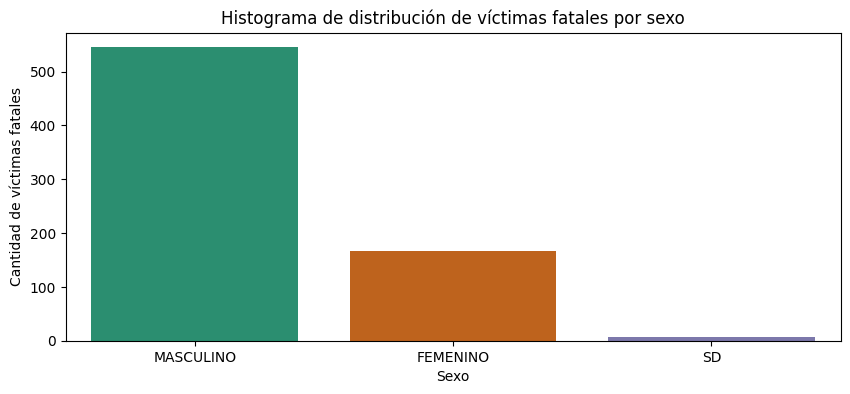

In [18]:
plt.figure(figsize=(10, 4))
# se filtran los valores sin datos o nulos 
df_filtrado = df[df["Sexo"] != 0]

#Se cuentan los datos de la columna y se calcula la frecuencia en que se distribuye
sns.countplot(df_filtrado, x='Sexo', palette="Dark2")

plt.ylabel("Cantidad de víctimas fatales")
plt.xlabel("Sexo")
plt.title("Histograma de distribución de víctimas fatales por sexo")

plt.show()

#### **Conclusión**

El grafico demuestra la diferencia de cantidad de victimas de cada sexo siendo el masculino el que mas cantidad posee

### B - Variables Categóricas

### Distribución por `Comuna`

In [19]:
#Se crea un dataset con el número de víctimas por Barrio y Comuna
Total_comuna=df.groupby(["Comuna", "Barrios"])["Num víctimas"].sum().reset_index()
Total_comuna=Total_comuna.sort_values(by="Num víctimas", ascending=False)
Total_comuna

,Comuna,Barrios,Num víctimas
0,Comuna 1,CONSTITUCION - MONTSERRAT - PUERTO MADERO - RE...,101
9,Comuna 4,BARRACAS - BOCA - NUEVA POMPEYA - PARQUE PATRI...,81
14,Comuna 9,LINIERS - MATADEROS - PARQUE AVELLANEDA,74
13,Comuna 8,VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI,70
12,Comuna 7,FLORES - PARQUE CHACABUCO,65
8,Comuna 3,BALVANERA - SAN CRISTOBAL,48
6,Comuna 15,AGRONOMIA - CHACARITA - PARQUE CHAS - PATERN...,47
3,Comuna 12,COGHLAN - SAAVEDRA - VILLA PUEYRREDON - VILLA ...,43
4,Comuna 13,BELGRANO - COLEGIALES - NUÃ‘EZ,39
5,Comuna 14,PALERMO,38


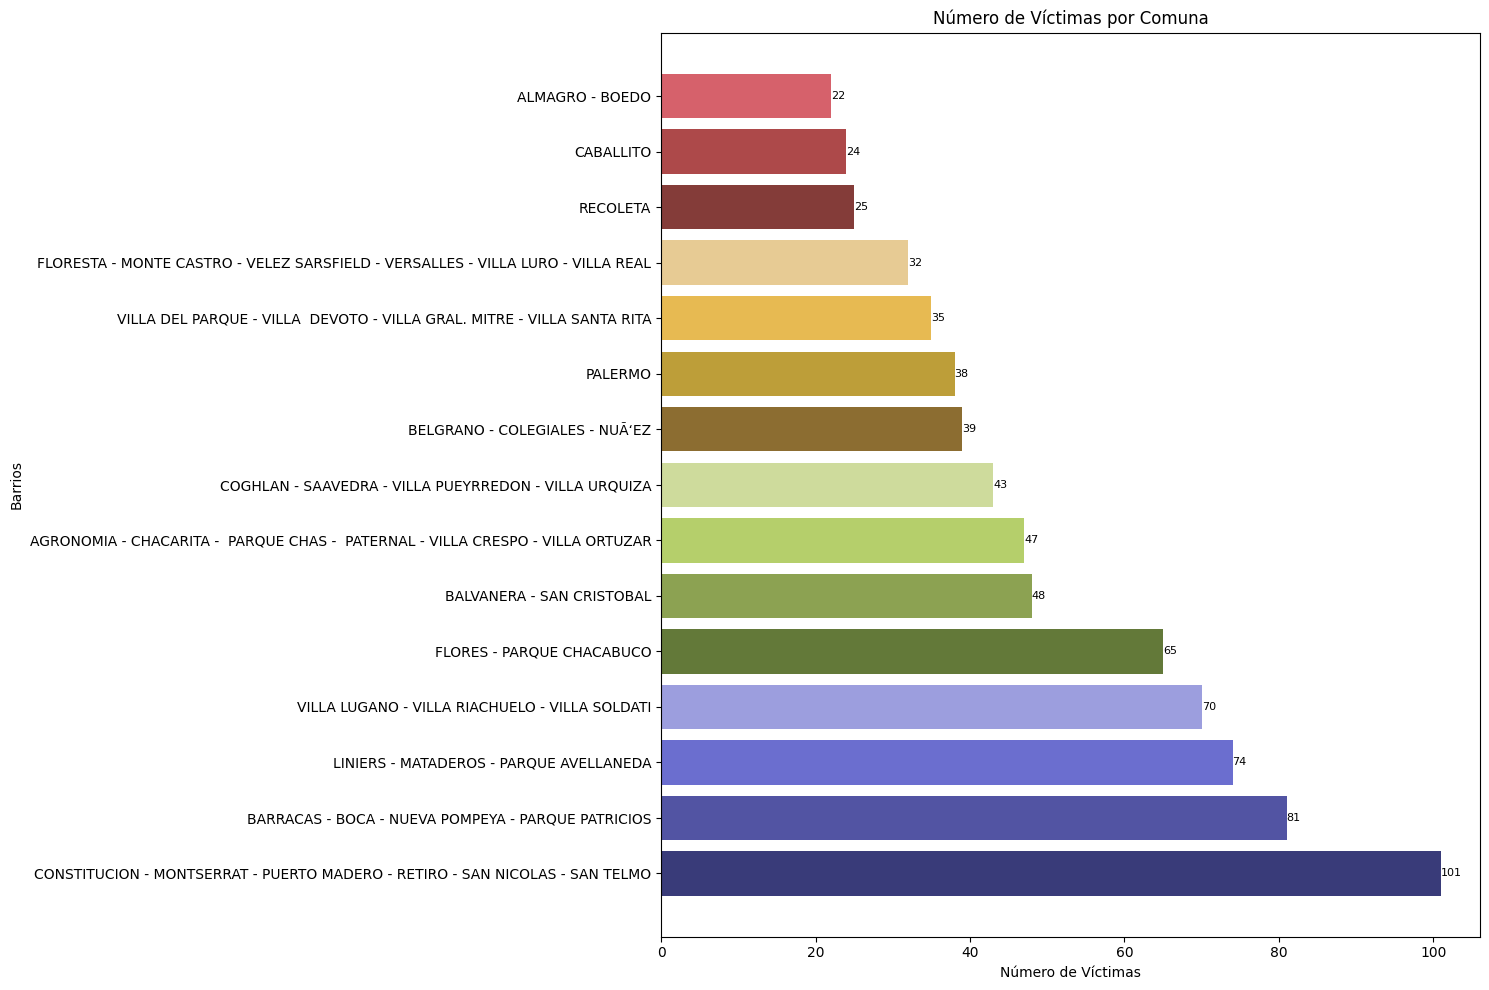

In [20]:
# Crear el gráfico de barras horizontales
plt.figure(figsize=(15, 10))

# Colores para las barras
colores = plt.cm.tab20b(range(len(Total_comuna)))

# Dibujar las barras horizontales
plt.barh(Total_comuna["Barrios"], Total_comuna["Num víctimas"], color=colores)

# Etiquetas de eje x e y
plt.xlabel('Número de Víctimas')
plt.ylabel('Barrios')

# Título del gráfico
plt.title('Número de Víctimas por Comuna')

# Agregar el número de víctimas sobre cada barra
for i, v in enumerate(Total_comuna["Num víctimas"]):
    plt.text(v, i, str(v), va='center', fontsize=8, color='black')


plt.tight_layout()
plt.show()

#### **Conclusión**
- El dataset presenta el total de 15 comunas que conforman los distintos barrios de CABA. Cada comuna esta formada por uno o varios Barrios.
- De la tabla `Total_comunas` resultan con mayor cantidad de víctimas fatales las Comunas 1, 4, 9, 8 y 7.
- La comuna 1 supera por 20 en víctimas a la comuna 4, que le sigue en orden 

Ello sugiere que pueden ser Barrios donde existan arterias muy transitadas al momento de la entrada ó salida del horario laboral

### Distribución de los `Tipos de Calles` donde suceden los siniestros

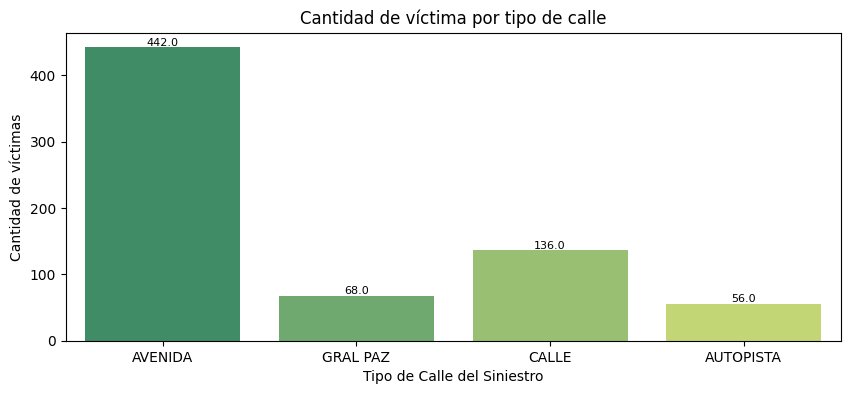

In [21]:
#Se crea el gráfico de barras
plt.figure(figsize=(10, 4))

ax=sns.countplot(df, x='Tipo de calle', palette="summer")

# Agrega el número de víctimas en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=8)

#Se titulan los ejes
plt.xlabel('Tipo de Calle del Siniestro')
plt.ylabel('Cantidad de víctimas')
plt.title('Cantidad de víctima por tipo de calle')

plt.show()

#### **Conclusión**
- Del análisis del gráfico resulta que el mayor número de víctimas fatales se producen en `Avenida`; secundado por `Calle`.

### Distribución de `Participantes` en los siniestros

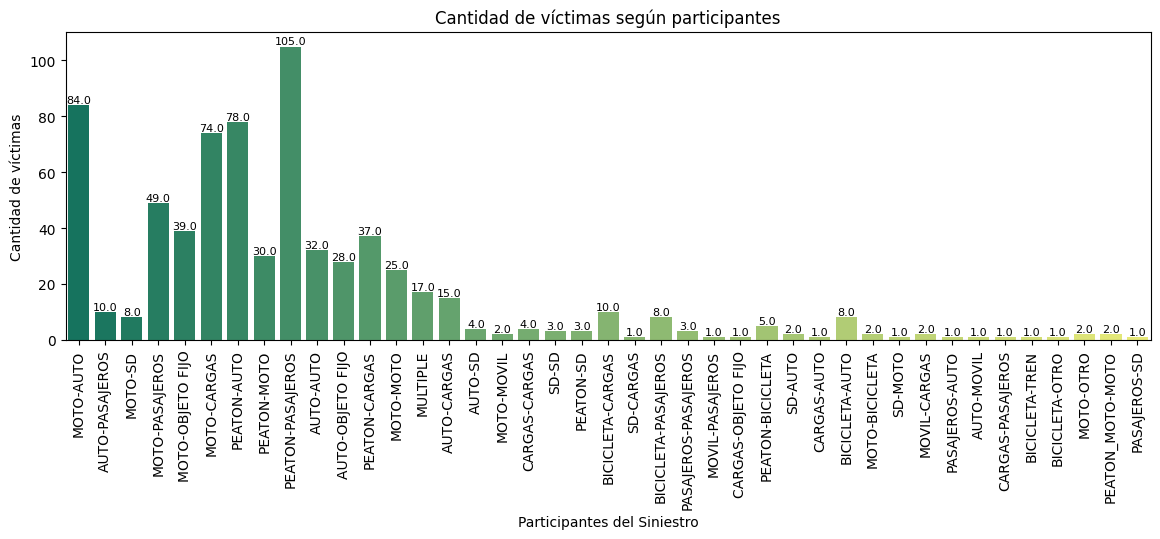

In [22]:
#Se crea el gráfico de barras
plt.figure(figsize=(14, 4))

ax=sns.countplot(df, x="Participantes", palette="summer")

# Agrega el número de víctimas en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=8)

#Se ubican los titulos de las barras en 90 grados
plt.xticks(rotation=90)

#Se titulan los ejes
plt.xlabel('Participantes del Siniestro')
plt.ylabel('Cantidad de víctimas')
plt.title('Cantidad de víctimas según participantes')

plt.show()

#### **Conclusión**
- Los valores de participación que concentran más víctimas están en `PEATON-PASAJEROS`, esto según el diccionario de datos, se refiere a Peatón: es cualquier víctima distinta de cualquier ocupante de un vehículo; Pasajero: es cualquier persona que se encuentra dentro, descendiendo o ascendiendo del transporte público u omnibús de larga distancia.
- Le siguen en importancia de víctimas `MOTO-AUTO` , `PEATON-AUTO` y `MOTO-CARGAS`

En la columna `Participantes` puede interpretarse que la primer palabra se relaciona a quien fue la `Víctima` y la segunda palabra se refiere al `Acusado`

### Distribución de `Acusados` en los siniestros

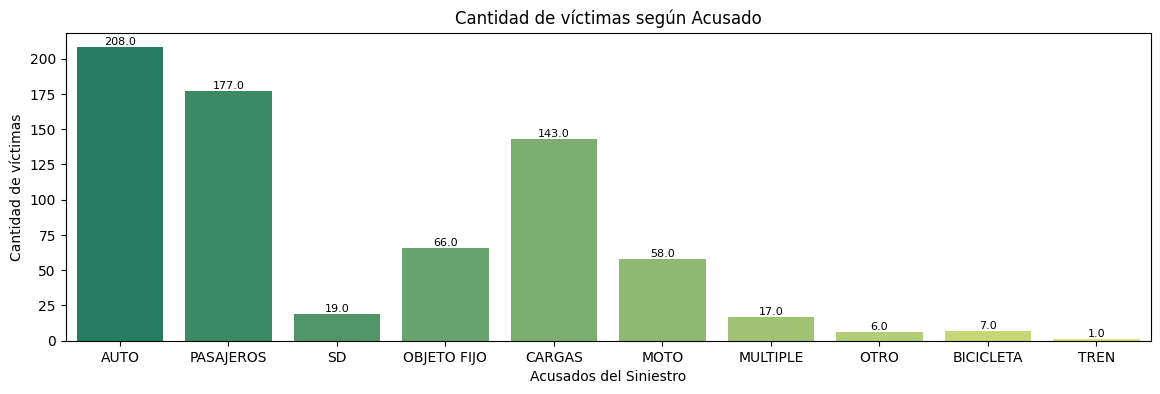

In [23]:
#Se crea el gráfico de barras
plt.figure(figsize=(14, 4))

ax=sns.countplot(df, x="Acusado", palette="summer")

# Agrega el número de víctimas en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=8)


#Se titulan los ejes
plt.xlabel('Acusados del Siniestro')
plt.ylabel('Cantidad de víctimas')
plt.title('Cantidad de víctimas según Acusado')

plt.show()

#### **Conclusión**
- Se puede visualizar que los que causan más víctimas son los  `Autos`, `Cargas` y `Pasajeros`. Esto se relaciona con el punto anterior.

### Distribución de `Víctimas` en los siniestros

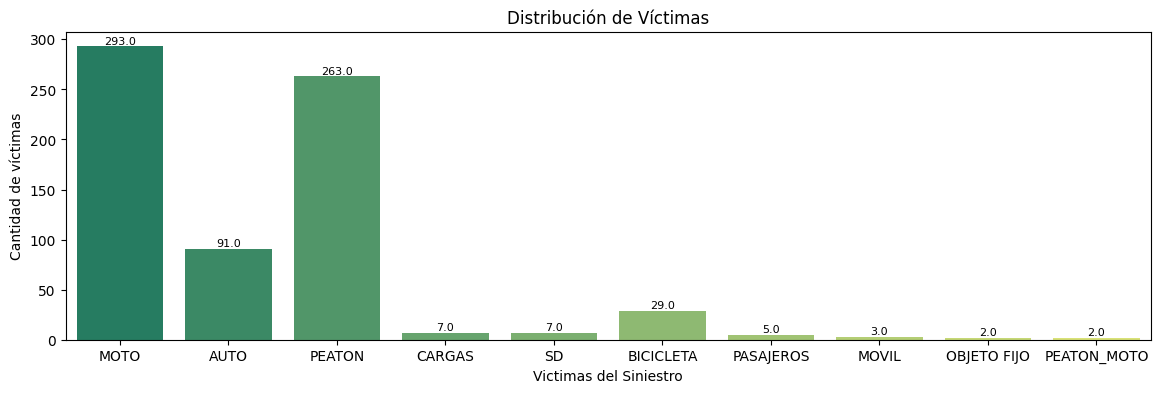

In [24]:
#Se crea el gráfico de barras
plt.figure(figsize=(14, 4))

ax=sns.countplot(df, x="Victima", palette="summer")

# Agrega el número de víctimas en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=8)


#Se titulan los ejes
plt.xlabel('Victimas del Siniestro')
plt.ylabel('Cantidad de víctimas')
plt.title('Distribución de Víctimas')

plt.show()

#### **Conclusión**
- Se puede visualizar que las víctimas son  `Moto`, `Peaton` y `Carga`. Esto se relaciona con ambos puntos anteriores.

#### **Conclusión Final**

El analisís demuestra que la mayor cantidad de victimas son las motos y los peatones y que al mismo tiempo el lugar donde mas ocurren siniestros es en avenidas. Siendo estos los datos mas importantes.

Tambien se pudo observar que en la gran mayoria, las principales victimas de los siniestros son masculinos. Y la comuna donde mas ocurren es en la número 1


Toda esta informacion la voy a utilizar para un [DashBoard](https://github.com/Daffoluar/proyecto-ind-2/blob/main/PI2.pbix) en donde se podra ver toda la informacion de mejor manera y mas organizada para el entendimiento de todos.